<a href="https://colab.research.google.com/github/HunterAshby/Build-Week-2/blob/master/Build_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/HunterAshby/Build-Week-2/master/Datasets/high_diamond_ranked_10min.csv')
print(df.shape)
df.head()

(9879, 40)


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df['blueAvgLevel'].mean()

6.91600364409359

In [ ]:
from sklearn.model_selection import train_test_split
df.drop(['gameId', 'redExperienceDiff', 'redGoldDiff'], axis=1, inplace=True)
df.head()

target='blueWins'
y = df[target]
X = df.drop(target, axis=1)
selector = SelectKBest(k=10)
selector.fit(X, y)
mask = selector.get_support()

XT = X[X.columns[mask]]

X_train, X_val, y_train, y_val = train_test_split(XT, y, test_size=0.2, random_state=42)

In [ ]:
print('Baseline: ', y.value_counts(normalize=True).max())

Baseline:  0.5009616357930965


In [ ]:
model_LR = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LogisticRegression()
)

model_LR.fit(X_train, y_train)

print('Training Accuracy: ', model_LR.score(X_train, y_train))
print('Validation Accuracy: ', model_LR.score(X_val, y_val))

Training Accuracy:  0.7285840819941795
Validation Accuracy:  0.7236842105263158


In [ ]:
model_RFC = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, max_depth=10)
)

model_RFC.fit(X_train, y_train)

print('Training Accuracy:', model_RFC.score(X_train, y_train))
print('Validation Accuracy:', model_RFC.score(X_val, y_val))

Training Accuracy: 0.829052258635961
Validation Accuracy: 0.715080971659919


In [ ]:
import joblib
from joblib import dump

dump(model_LR, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [ ]:
import sklearn
import pdpbox
import category_encoders
print(f'pdpbox=={pdpbox.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={category_encoders.__version__}')
print(f'joblib=={joblib.__version__}')

pdpbox==0.2.0
scikit-learn==0.22.2.post1
category_encoders==2.2.2
joblib==0.16.0


In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression Roc Auc Score: ', roc_auc_score(model_LR.predict(X_val), y_val))
print('Random Forset Roc Auc Score: ', roc_auc_score(model_RFC.predict(X_val), y_val))

Logistic Regression Roc Auc Score:  0.7236785895393567
Random Forset Roc Auc Score:  0.7152203856749311


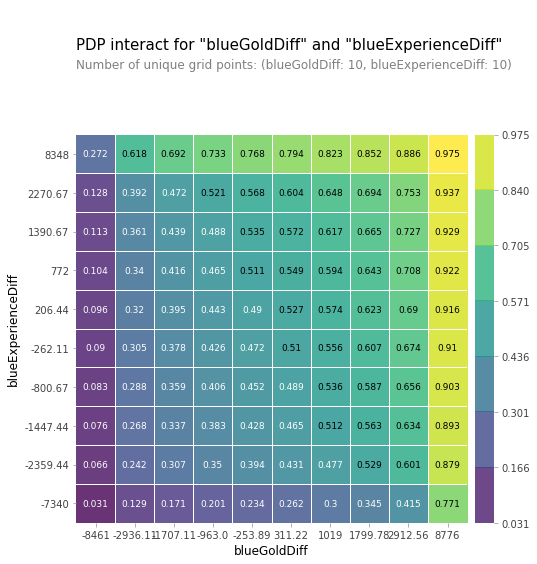

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot

features = ['blueGoldDiff', 'blueExperienceDiff']

interaction = pdp_interact(
    model=model_LR,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

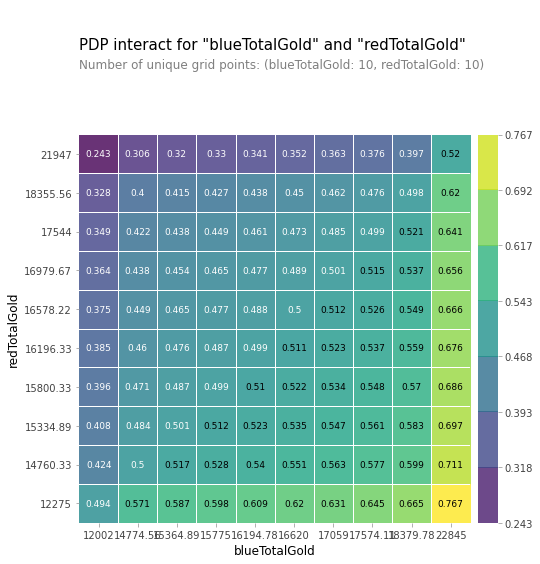

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot

features = ['blueTotalGold', 'redTotalGold']

interaction = pdp_interact(
    model=model_LR,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
blueTotalGold = 16503
redTotalGold = 16489
blueTotalExperience = 17928
redTotalExperience = 17961
blueAvgLevel = 6.92
redAvgLevel = 6.93

blueGoldPerMin = blueTotalGold/10
redGoldPerMin = redTotalGold/10
blueGoldDiff = blueTotalGold - redTotalGold
blueExperienceDiff = blueTotalExperience - redTotalExperience

app_prof = pd.DataFrame(
    columns=['blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueGoldDiff',
                'blueExperienceDiff', 'blueGoldPerMin', 'redTotalGold', 'redAvgLevel',
                'redTotalExperience', 'redGoldPerMin'],
             data=[[blueTotalGold, blueAvgLevel, blueTotalExperience, blueGoldDiff,
                blueExperienceDiff, blueGoldPerMin, redTotalGold, redAvgLevel,
                redTotalExperience, redGoldPerMin]]
)

In [ ]:
import shap
#app_prof = X_val.iloc[[1]]
explainer = shap.TreeExplainer(model_RFC.named_steps['randomforestclassifier'])
shap_values = explainer.shap_values(app_prof)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=app_prof
)

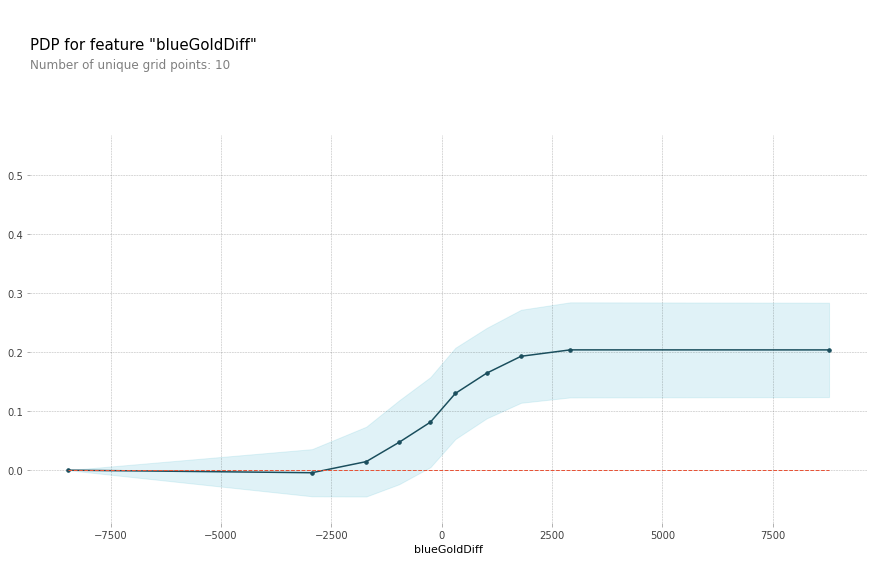

In [ ]:
feature = 'blueGoldDiff'

isolated = pdp_isolate(
    model=model_RFC,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

In [ ]:
import plotly.express as px
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model_LR, X_val, y_val, n_jobs=-1)

data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df_perm_imp = pd.DataFrame(data, index=X_train.columns)
df_perm_imp.sort_values('importances_mean', ascending=True, inplace=True)

fig = px.bar(x=df_perm_imp.importances_mean, 
             y=df_perm_imp.index, orientation='h', 
             title='Feature Importance For Predicting Blue Team Win',
             labels={
                 'x': '',
                 'y': ''
             })

fig.show()